In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import impedance
from impedance.models.circuits import CustomCircuit

from impedance.visualization import plot_nyquist
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
from impedance.validation import linKK
from sklearn.linear_model import LinearRegression

In [2]:
#Converts text file exported from Biologic into form ready for preprocessing

data = 'LFP_475um_Graphite_EMC50_EC50_PEIS_steps_02_PEIS_C01.txt'

df = pd.read_csv(data, sep="\t", encoding= 'unicode_escape')
df1 = df.iloc[:, 0:3] 
df1 = df1.rename(columns={'freq/Hz': 'freq_Hz', 'Re(Z)/Ohm':'Re_Z_Ohm', '-Im(Z)/Ohm':'Im_Z_Ohm'}) 

df1.Im_Z_Ohm = df1.Im_Z_Ohm*-1

s = df1['freq_Hz'].shift() <= df1['freq_Hz']

#s = df['I_mA'].shift().eq(0) & df['control_mA'].lt(0)
df1['segment'] = s.cumsum() + 1

df2 = df1[df1['segment'] == 1] 

df2.to_csv("data.csv", index = False)



In [3]:
#Formats dataframe for impedance fitting and analysis

freq, Z = preprocessing.readCSV('./data.csv')

#This Biologic prepreprocessing code does not work.
#freq, Z = preprocessing.readBioLogic('./319_02_PEIS_CF1.mpr')

#This part seems to get rid of NaN values
freq, Z = preprocessing.cropFrequencies(freq, Z, freqmin=0, freqmax=None)



In [4]:
#Crop data to only retain part of data to fit

freqmin1 = 5


freq1, Z1 = preprocessing.cropFrequencies(freq, Z, freqmin=freqmin1, freqmax=None)

In [5]:
#Validate data with Kramers-Kronig (KK) method
#doi: 10.1016/j.electacta.2014.01.034
#M is the number of RC elements, mu is the 'u' given by eq. 21 in linked paper

mask = freq > 4
freq_kk = freq [mask]
Z_KK = Z[mask]

M, mu, Z_linKK, res_real, res_imag = linKK(freq_kk, Z_KK, c=.5, max_M=100, fit_type='complex', add_cap=True)

#print('\nCompleted Lin-KK Fit\nM = {:d}\nmu = {:.2f}'.format(M, mu))

10 0.8459203361450411 0.010043963734924681


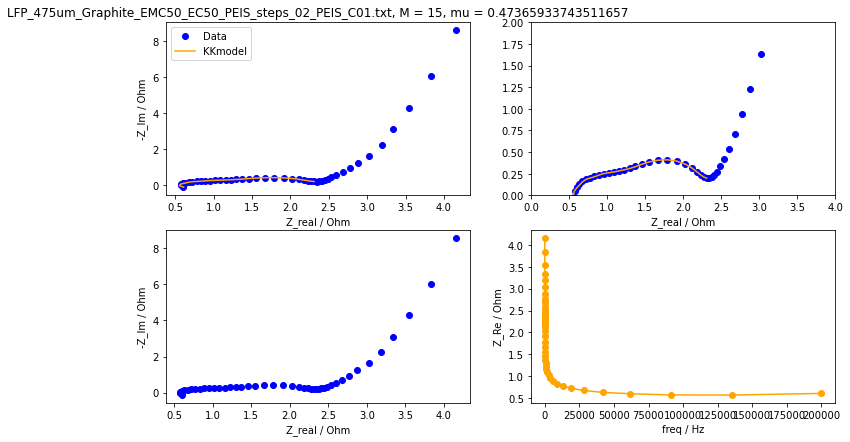

In [6]:
#Quick Nyquist visualisation to assess basic parameters and do KK fit

fig, ax = plt.subplots(2, 2, figsize=(12,7))
lns1 = ax[0, 0].plot(Z.real, -Z.imag, color='blue', marker ='o', linestyle ='None', label = "Data") 
lns2 = ax[0, 0].plot(Z_linKK.real, -Z_linKK.imag, color='orange', linestyle ='-', label = "KKmodel") 
ax[0, 0].set_ylabel('-Z_Im / Ohm')
ax[0, 0].set_xlabel('Z_real / Ohm')

#Zoom into early semi-circles

#xlim = 10
#xlim2 = R_lowf - 50
#ylim = 50

#ax[0, 0].set_xlim(0, xlim)
#ax[0, 0].set_ylim(0, ylim)

ax[0, 0].set_title(str(data)+', M = '+str(M)+', mu = '+str(mu))

lns3 = ax[0,1].plot(Z.real, -Z.imag, color='blue', marker ='o', linestyle ='None', label = "Data")
lns4 = ax[0,1].plot(Z_linKK.real, -Z_linKK.imag, color='orange', linestyle ='-', label = "KKmodel")

ax[0,1].set_xlabel('Z_real / Ohm')

ax[0,1].set_xlim(0, 4)
ax[0,1].set_ylim(0, 2)

lns6 = ax[1,0].plot(Z.real, -Z.imag, color='blue', linestyle ='None', marker ='o', label = "Z-real") 

ax[1,0].set_ylabel('-Z_Im / Ohm')
ax[1,0].set_xlabel('Z_real / Ohm')
#ax[1, 0].set_xlim(xlim2, max(Z.real))
#ax[1,0].set_xlim(0, 100)
#ax[1,0].set_ylim(0, 300)

lns8 = ax[1,1].plot(freq, Z.real, color='orange', marker ='o', label = "Z-real") 
#ax[1,1].set_xlim(0, 8)
ax[1,1].set_ylabel('Z_Re / Ohm')
ax[1,1].set_xlabel('freq / Hz')

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax[0, 0].legend(lns, labs, loc='upper left')

plt.show()

In [8]:
#Define circuit element and build starting guess model
#Transmission line model TLMQ: Rion, Qs, gamma = p[0], p[1], p[2]


#circuit1 = 'R0-TLMQ0'
#initial_guess1 = [0.0091, 0.932]
#constant1 = {'R0':0.7, 'TLMQ0_0':3.5}
#circuit1 = CustomCircuit(circuit1, initial_guess=initial_guess1,
#                        constants = constant1 )

circuit = 'R0-p(R1, C0)-p(R2, C1)'
initial_guess1 = [0.554, 0.648, 1.5]
constant1 = {'C1': 0.00137, 'C2':0.65}#, 'R3': 1.18}#, 'CPE2_0': 0.019, 'CPE2_1': 0.68}
circuit = CustomCircuit(circuit, initial_guess=initial_guess1, constants=constant1)


#Circuit element and model for trial limited model

#circuit2 = 'R0-p(R1,CPE0)-p(R2,CPE1)-W0'
#initial_guess2 = [0.6, 1.5, 0.0002, 0.95, 1, 0.0002, 0.95, 0.0002]
#constant2 = {'R0':R1_highf, 'TLMQ0_0':Rion1} 
#circuit2 = CustomCircuit(circuit2, initial_guess=initial_guess2,
 #                        constants = constant2)

#circuit3 = 'R0-p(R1,CPE0)-p(R2,CPE1)-W0'

#constant3 = {'R0':R_highf, 'TLMQ0_0':8, 'TLMQ0_1':7.17e-4, 'TLMQ0_2':0.932 }
#circuit3 = CustomCircuit(circuit3, constants = constant3)


ValueError:  C not in allowed elements (dict_keys(['W', 'C', 'Wo', 'T', 'Ws', 'R', 's', 'La', 'K', 'G', 'p', 'Gs', 'L', 'CPE', 'TLMQ', '__builtins__']))

In [ ]:
#Crop data to only retain part of data to fit

freqmin1 = 5

freq1, Z1 = preprocessing.cropFrequencies(freq, Z, freqmin=freqmin1, freqmax=None)

In [ ]:
# Fit EIS model for full data

circuit1.fit(freq1, Z1)
Z_fit = circuit1.predict(freq1)

#Fit EIS model for part of the data
#circuit2.fit(freq1, Z1)
#Z_fit1 = circuit2.predict(freq1)

In [ ]:
#Tease out and calculate values for phase angle and Z_mod (to avoid using built in visualise package)

Z_mod_exp = np.sqrt((Z1.real*Z1.real) + (Z1.imag*Z1.imag))
phase_exp = np.arctan(Z1.imag/Z1.real)*180/np.pi

Z_mod_fit = np.sqrt((Z_fit.real*Z_fit.real) + (Z_fit.imag*Z_fit.imag))
phase_fit = np.arctan(Z_fit.imag/Z_fit.real)*180/np.pi

#Z_mod_fit1 = np.sqrt((Z_fit1.real*Z_fit1.real) + (Z_fit1.imag*Z_fit1.imag))
#phase_fit1 = np.arctan(Z_fit1.imag/Z_fit1.real)*180/np.pi

In [ ]:
#Save values into dataframe and export

df_res = pd.DataFrame()

df_res['freq_exp'] = freq1
df_res['Z_Re_exp'] = Z1.real
df_res['nZ_Im_exp'] = Z1.imag
df_res['Z_mod_exp'] = Z_mod_exp
df_res['phase_exp'] = phase_exp

df_res['Z_Re_fit'] = Z_fit.real
df_res['nZ_Im_fit'] = -Z_fit.imag
df_res['Z_mod_fit'] = Z_mod_fit
df_res['phase_fit'] = phase_fit



In [ ]:
#Plot data and model

fig, ax = plt.subplot_mosaic([['A)','B)'], ['C)', 'C)'], ['D)', 'D)']], figsize=(8,15))

#lns1 = ax.plot(df.Re_Z_Ohm, -df.Im_Z_Ohm, color='blue', marker ='o') 
lns1 = ax['A)'].plot(Z1.real, -Z1.imag, color='blue', marker ='o', linestyle ='None', label = "Data") 
lns2 = ax['A)'].plot(Z_fit.real, -Z_fit.imag, color='orange', linestyle ='-', label = "Model") 
#lns3 = ax['A)'].plot(Z_fit1.real, -Z_fit1.imag, color='red', linestyle ='-', label = "Model_1") 
#lns3a = ax['A)'].plot(Z_fit.real, Z_fit.real, color='black', linewidth=1, linestyle ='--')

lns10 = ax['B)'].plot(Z1.real, -Z1.imag, color='blue', marker ='o', linestyle ='None', label = "Data") 
lns13 = ax['B)'].plot(Z_fit.real, -Z_fit.imag, color='orange', linestyle ='-', label = "Model") 
#lns12 = ax['B)'].plot(Z_fit1.real, -Z_fit1.imag, color='red', linestyle ='-', label = "Model_1") 

lns4 = ax['C)'].plot(freq1, Z_mod_exp, color='blue', marker ='o', linestyle ='None', label = "Data") 
#lns5 = ax['C)'].plot(freq, Z_mod_fit, color='orange', linestyle ='-', label = "Model") 
#lns6 = ax['C)'].plot(freq1, Z_mod_fit1, color='red', linestyle ='-', label = "Model_1") 

lns7 = ax['D)'].plot(freq1, phase_exp, color='blue', marker ='o', linestyle ='None', label = "Data") 
#lns8 = ax['D)'].plot(freq, phase_fit, color='orange', linestyle ='-', label = "Model")
#lns9 = ax['D)'].plot(freq1, phase_fit1, color='red', linestyle ='-', label = "Model_1")

ax['A)'].set_title(str(data)+', Nyquist plot, Full fit (Model): '+str(circuit1))
ax['A)'].set_ylabel('-Z_Im / Ohm')
ax['A)'].set_xlabel('Z_real / Ohm')
ax['A)'].set_xlim(0, 4)

ax['B)'].set_title(str(data)+', Nyquist plot, Partial fit')
ax['B)'].set_ylabel('-Z_Im / Ohm')
ax['B)'].set_xlabel('Z_real / Ohm')
ax['B)'].set_xlim(0, 3)
ax['B)'].set_ylim(0, 1)

ax['C)'].set_title('Bode plot: Z_mod')
ax['C)'].set_xlabel('Freq / Hz')
ax['C)'].set_ylabel('Z_mod / Ohm')
ax['C)'].set_xscale('log')
ax['C)'].set_xlim(5, 10000)
ax['C)'].set_ylim(0, 100)

ax['D)'].set_title('Bode plot: Phase angle')
ax['D)'].set_xlabel('Freq / Hz')
ax['D)'].set_ylabel('Phase angle / deg')
ax['D)'].set_xscale('log')
ax['D)'].set_xlim(5, 10000)

lns = lns1 + lns2 +lns3 
#lnsa = lns10 + lns12

labs = [l.get_label() for l in lns]
ax['A)'].legend(lns, labs, loc='lower right')
ax['B)'].legend(lnsa, labs, loc='lower right')
ax['C)'].legend(lns, labs, loc='upper right')
ax['D)'].legend(lns, labs, loc='lower right')

# set the spacing between subplots
plt.subplots_adjust(left=0.5,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

In [ ]:
print(circuit1)

In [ ]:
circuit1.get_param_names()